In [14]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Align.Applications import MafftCommandline
from Bio import AlignIO
from Bio.motifs import Motif
from Bio.Align import AlignInfo
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
import os
from Bio import motifs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# Load data

In [2]:
# Output FASTA file that will contain only sequences with label 1
output1_fasta = "Train_label_1.fasta"

# Parse the input FASTA file
sequences = SeqIO.parse("Data/Train.fasta", "fasta")

# Filter sequences based on label in the ID
sequences_1 = (seq for seq in sequences if seq.id.endswith('_label_1'))

# Write the filtered sequences to the output FASTA file
with open(output1_fasta, "w") as output_handle:
    SeqIO.write(sequences_1, output_handle, "fasta")


In [3]:
# Output FASTA file that will contain only sequences with label 1
output0_fasta = "Train_label_0.fasta"

# Parse the input FASTA file
sequences = SeqIO.parse("Data/Train.fasta", "fasta")

# Filter sequences based on label in the ID
sequences_0 = (seq for seq in sequences if seq.id.endswith('_label_0'))

# Write the filtered sequences to the output FASTA file
with open(output0_fasta, "w") as output_handle:
    SeqIO.write(sequences_0, output_handle, "fasta")

# Visualise the distributions of lengths of label 1 & 0 sequences

In [4]:
sequence1_lengths = [len(record.seq) for record in SeqIO.parse("Train_label_1.fasta", "fasta")]

In [5]:
sequence0_lengths = [len(record.seq) for record in SeqIO.parse("Train_label_0.fasta", "fasta")]

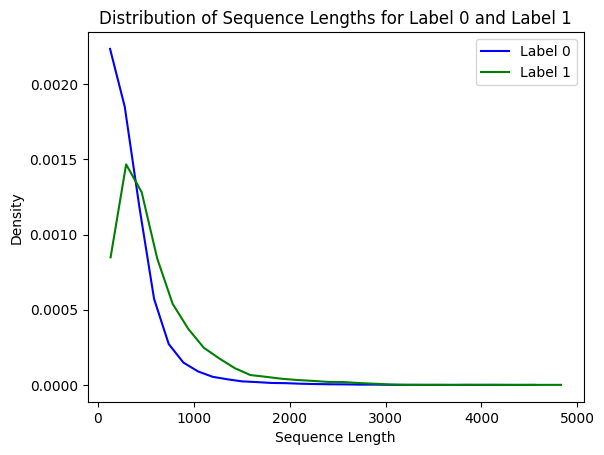

In [6]:
# Create a function to plot the distribution as a line plot
def plot_length_distribution(lengths, label, color):
    counts, bin_edges = np.histogram(lengths, bins=30, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(bin_centers, counts, label=label, color=color)

# Plot line distributions for both labels
plot_length_distribution(sequence0_lengths, 'Label 0', 'blue')
plot_length_distribution(sequence1_lengths, 'Label 1', 'green')

# Add titles and labels
plt.title('Distribution of Sequence Lengths for Label 0 and Label 1')
plt.xlabel('Sequence Length')
plt.ylabel('Density')

# Add legend to differentiate between the two labels
plt.legend()

# Show the plot
plt.show()

# Perform Multiple Sequence Alignment

## For Class 1

In [ ]:
from Bio.Align.Applications import MafftCommandline
from Bio import AlignIO
from Bio.Align import AlignInfo
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef, roc_auc_score

In [8]:
# # Define the path to your fasta file
# fasta_file = "Train_label_1.fasta"

# # Run MAFFT to perform the MSA
# mafft_cline = MafftCommandline(input=fasta_file)
# stdout, stderr = mafft_cline()

In [9]:
# # Save the alignment to a file
# with open("train_label_1_aligned.fasta", "w") as aligned_file:
#     aligned_file.write(stdout)

# # Read the aligned sequences
# alignment = AlignIO.read("train_label_1_aligned.fasta", "fasta")


## For Class 0

In [10]:
# # Define the path to your fasta file
# fasta_file = "Train_label_0.fasta"

# # Run MAFFT to perform the MSA
# mafft_cline = MafftCommandline(input=fasta_file, auto = True)
# stdout, stderr = mafft_cline()

In [11]:
# # Save the alignment to a file
# with open("train_label_0_aligned.fasta", "w") as aligned_file:
#     aligned_file.write(stdout)

# # Read the aligned sequences
# alignment = AlignIO.read("train_label_1_aligned.fasta", "fasta")

In [12]:
# # Create summary information for the alignment
# summary_align = AlignInfo.SummaryInfo(alignment)

# # Generate the Position-Specific Scoring Matrix (PSSM)
# pssm = summary_align.pos_specific_score_matrix()


In [13]:
# # Load your alignment using AlignIO
# alignment = AlignIO.read("train_label_1_aligned.fasta", "fasta")  # Adjust the file format as needed

# # Extract sequences from alignment to create a motif
# sequences = [str(record.seq) for record in alignment]

# # Create a motif from the list of sequences (no need for the alphabet argument)
# motif = motifs.create(sequences)

# # Get the position-specific scoring matrix (PSSM)
# counts = motif.counts

# # Optionally calculate the consensus from the counts
# consensus = motif.consensus

In [9]:
def calculate_pssm(alignment_file):
    # Load the alignment file
    alignment = AlignIO.read(alignment_file, "fasta")
    
    # Extract sequences from alignment
    sequences = [str(record.seq) for record in alignment]
    
    # Create a motif from the sequences
    motif = motifs.create(sequences)
    
    # Return the Position-Specific Scoring Matrix (PSSM)
    return motif.pssm

In [16]:
def score_sequence_against_pssm(pssm, sequence):
    # Convert the sequence into a motif-style sequence (as a Seq object)
    seq = Seq(sequence)
    
    # Score the sequence against the PSSM
    score = pssm.calculate(seq)
    return score

In [17]:
def classify_sequence(sequence, pssm_class_1, pssm_class_0):
    # Score the sequence against both class 1 and class 0 PSSMs
    score_class_1 = score_sequence_against_pssm(pssm_class_1, sequence)
    score_class_0 = score_sequence_against_pssm(pssm_class_0, sequence)
    
    # Return the class with the higher score
    return 1 if score_class_1 > score_class_0 else 0

In [18]:
def evaluate_model(test_file, pssm_class_1, pssm_class_0):
    # Load the test sequences
    test_sequences = SeqIO.parse(test_file, "fasta")
    
    true_labels = []
    predicted_labels = []
    
    # Loop through each test sequence and classify it
    for record in test_sequences:
        sequence = str(record.seq)
        # Here, we assume the sequence ID contains the true label (e.g., ">sequence_1" or ">sequence_0")
        true_label = int(record.id.split('_')[-1])  # Adjust based on your test data format
        true_labels.append(true_label)
        
        # Classify the sequence
        predicted_label = classify_sequence(sequence, pssm_class_1, pssm_class_0)
        predicted_labels.append(predicted_label)
    
    # Calculate confusion matrix and other metrics
    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
    
    # Calculate sensitivity, specificity, MCC, and ROC-AUC
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    mcc = matthews_corrcoef(true_labels, predicted_labels)
    auc_roc = roc_auc_score(true_labels, predicted_labels)
    
    # Return all the metrics
    return {
        "confusion_matrix": (tn, fp, fn, tp),
        "sensitivity": sensitivity,
        "specificity": specificity,
        "MCC": mcc,
        "AUC_ROC": auc_roc
    }

In [ ]:
# Paths to your MSA files for class 1 and class 0
alignment_class_1 = "Data/aligned0.fasta"
alignment_class_0 = "Data/aligned1.fasta"

# Calculate PSSMs for both classes
pssm_class_1 = calculate_pssm(alignment_class_1)
pssm_class_0 = calculate_pssm(alignment_class_0)

# Test data file
test_file = "test.fasta"

# Evaluate the model
results = evaluate_model(test_file, pssm_class_1, pssm_class_0)

# Print results
print("Confusion Matrix (TN, FP, FN, TP):", results["confusion_matrix"])
print("Sensitivity:", results["sensitivity"])
print("Specificity:", results["specificity"])
print("MCC:", results["MCC"])
print("AUC-ROC:", results["AUC_ROC"])